In [1]:
import os
import sys
sys.path.insert(0, "../BlobOT")

import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)


240211


In [2]:
from BlobOT import KE, NLE, NLE_pos, Model
from BlobOT import draw_straight_lines, EarlyStopping, endpoint_cost

def blobLoss(X, model, positive=False):
  if not positive:
    return KE(X, model.z, model.params) + NLE(X, model.w, model.params)
  else:
    return KE(X, model.z, model.params) + NLE_pos(X, model.w, model.params)


def training_loop(model, optimizer, n=10000):
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,
                                                         patience=2, threshold=0,
                                                         factor=0.2)
  early_stopping = EarlyStopping(patience=5)

  losses=[]

  for i in range(1, 1+n):
    preds = model()
    loss = blobLoss(preds, model)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)
    early_stopping(loss)

    losses.append(loss.detach().numpy())

    if early_stopping.early_stop:
      print("Early stopping at", i, 'out of', n)
      return np.array(losses)

  return np.array(losses)



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, squareform

def plot_1d_paths(X, w, z, params=None, figsize=(10, 5), **kwargs):
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  if X.shape[-1] <= params['L']:
    X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)
  
  t = params['dt']*np.arange(params['L']+1)

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[0].plot(traj[:, 0], t,  color=[.5, .5, 1])
  
  y = X[:, :, -1]
  ax[0].scatter(X[:, 0, 0], np.zeros_like(X[:, 0, 0]), marker='+', c='b', label='Source')
  ax[0].scatter(w[:, 0], 1 + np.zeros_like(w[:, 0]), marker='x', c='r', label='Target')
  ax[0].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')
  ax[0].set(xlabel='Coordinate 1', ylabel='Time (t)', **kwargs)
  
  ax[1].scatter(w[:, 0], 1 + np.zeros_like(w[:, 0]), marker='x', c='r', label='Target')
  ax[1].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')
  
  for p in range(X.shape[0]):
    traj = X[p].T
    ax[1].plot(traj[(params['L']-1):, 0], t[(params['L']-1):],  color=[.5, .5, 1])

  ax[1].set(xlabel='Coordinate 1', ylabel='Time (t)',**kwargs)
  plt.legend()
  plt.tight_layout(pad=0)

# as N $\to \infty$ 

In [4]:
rng = np.random.RandomState(23)

d = 1
dt = 0.25
L = int(1/dt)

eps = 1e-2
lr = 3*eps/1e3
gd_steps = 2*int(1e6) # run it longer for straighter lines

params = {'d': d, 'dt': dt, 'L': L, 'lr': lr, 'n': gd_steps, 'eps': eps}

endpoint_costs = []

def T(x):
  return 0.5*x+2

Ns = [5, 10, 20, 40, 80, 100]

for N in Ns:
  print()

  params['N'] = N
  params['delta'] = N**(-0.99)
  
  print(params)

  # sample from source and target distributions
  z = np.linspace(0, 1, N, endpoint=True).reshape((N, d)) # can be changed to random samples
  w = T(z)

  w_tensor = torch.tensor(w)
  z_tensor = torch.tensor(z)

  # initialize to center of target distribution
  y0 = np.ones((N, d))*(T(0) + T(1))/2
  X0 = draw_straight_lines(z, y0, params['L']+1)

  # run gradient descent
  m = Model(torch.from_numpy(X0), w_tensor, z_tensor, params)
  opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
  losses = training_loop(m, opt, n=params['n'])
  
  # calculate error from OT map
  X = m.X.data.numpy()
  y = X[:,:,-1]

  c1 = endpoint_cost(y, T(z))
  endpoint_costs.append(c1)

  print('endpoint cost:', c1)

  plot_1d_paths(X, w, z, params)
  plt.savefig(os.path.join('../output/', f'delta_scaling_{date}-{N}.pdf'), dpi=100)
  plt.close('all')


{'d': 1, 'dt': 0.25, 'L': 4, 'lr': 2.9999999999999997e-05, 'n': 2000000, 'eps': 0.01, 'N': 5, 'delta': 0.20324491825346513}
Epoch 324360: reducing learning rate of group 0 to 6.0000e-06.
Epoch 324366: reducing learning rate of group 0 to 1.2000e-06.
Epoch 324372: reducing learning rate of group 0 to 2.4000e-07.
Epoch 324377: reducing learning rate of group 0 to 4.8000e-08.
Early stopping at 324379 out of 2000000
endpoint cost: 0.005568993608181547

{'d': 1, 'dt': 0.25, 'L': 4, 'lr': 2.9999999999999997e-05, 'n': 2000000, 'eps': 0.01, 'N': 10, 'delta': 0.10232929922807542}
Epoch 603744: reducing learning rate of group 0 to 6.0000e-06.
Epoch 603755: reducing learning rate of group 0 to 1.2000e-06.
Epoch 603758: reducing learning rate of group 0 to 2.4000e-07.
Epoch 603761: reducing learning rate of group 0 to 4.8000e-08.
Epoch 603769: reducing learning rate of group 0 to 9.6000e-09.
Early stopping at 603771 out of 2000000
endpoint cost: 0.002619058374906703

{'d': 1, 'dt': 0.25, 'L': 4, 

In [5]:
np.savez(os.path.join('../output/', f'delta_scaling_{date}.npz'), 
         endpoint_costs=np.array(endpoint_costs), 
         Ns=Ns, 
         params=params)

# Plotting

In [6]:
data = np.load(os.path.join('../output/', f'delta_scaling_{date}.npz'), allow_pickle=True)
print(data.files)
endpoint_costs = data['endpoint_costs']
Ns = data['Ns']
params = data['params']

['endpoint_costs', 'Ns', 'params']


[-1.76505979 -0.74885276]


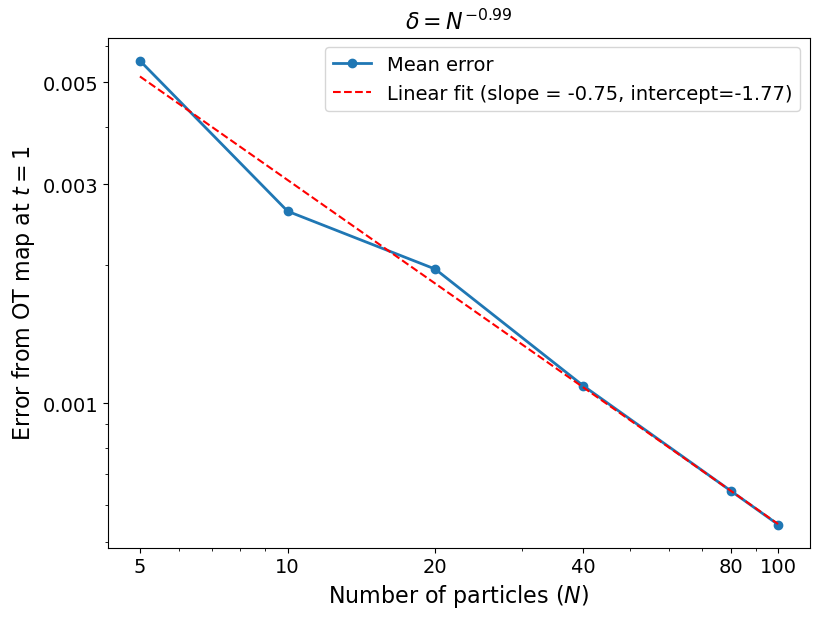

In [8]:
p = np.polynomial.polynomial.polyfit(np.log10(Ns), np.log10(endpoint_costs), 1)
print(p)

plt.figure(1, figsize=(8, 6))
plt.plot(Ns, endpoint_costs, linewidth=2, marker='o', label='Mean error')
plt.plot(Ns, 10**(p[0])*(Ns**p[1]), linestyle='--', color='r', label=f'Linear fit (slope = {np.around(p[1], 2)}, intercept={np.around(p[0], 2)})')
plt.xlabel(r'Number of particles ($N$)', fontsize=16)
plt.ylabel(r'Error from OT map at $t=1$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(Ns, [5, 10, 20, 40, 80, 100], fontsize=14)
plt.yticks([5*1e-3, 3*1e-3, 1e-3], [5*1e-3, 3*1e-3, 1e-3], fontsize=14)
plt.legend(fontsize=14)
plt.title(r'$\delta= N^{-0.99}$', fontsize=16)
plt.tight_layout(pad=0)
plt.savefig(os.path.join('../output/', f'delta_scaling_{date}_loglog_endpoint.pdf'), dpi=300)
plt.show()